In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/ubuntu/Dacon/jin/ct/src


In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch

from sklearn.model_selection import KFold

## Custom Modules

In [4]:
from datasets.datasets import CT_Dataset

In [5]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results.
    Args:
        seed (int): Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True   
seed_everything(1015)    

In [6]:
device = torch.device('cuda:1')
# load metadf
images_paths = pd.read_csv('../data/folds.csv')
output_dir = '../output/'

## 수정 필요 folds.csv를 입력으로 받을 수 있도록, 나누어진 fold가 folds.csv 에 포함되게(seed_everything 을 계속 호출할 필요가 없음)

추론과정간 folds 를 다시 생성하기 때문에 leakage 발생가능

In [7]:
path = "../data/normalization"
images_paths = os.listdir(path + '/img/')
images_paths.pop(-1)
images_paths = np.array(images_paths)
train_images = images_paths[len(images_paths) // 10 : ]
test_images  = images_paths[:len(images_paths) // 10]
kfold = KFold(n_splits=5, shuffle = False)
target_fold_index = 1
train_metrics_list = []
valid_metrics_list = []

In [8]:
model = torch.load("../models/unet_effb3/efficientnet-b3_0.8801loss_1epochs.pth", map_location=device)

CLASSES = 4
train_dataset = CT_Dataset(
            path = path,
            imglist = images_paths,
            augmentation = None,#get_training_augmentation(), 
            preprocessing = None,#get_preprocessing(preprocessing_fn),
            classes=CLASSES,
        )

/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2247: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


255

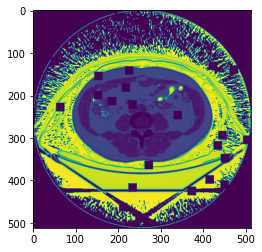

In [20]:
rint = np.random.randint(train_dataset.__len__())
plt.imshow(train_dataset[rint][0][0,...])

img = train_dataset[rint][0][0,...]
img = (img*255).astype(np.uint8)
plt.imshow(img * 255)

img.max()

/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


True

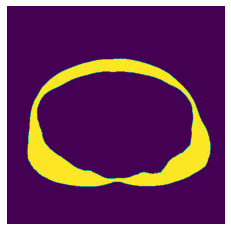

In [15]:
cv2.imwrite(output_dir + "original.png", img * 255)

pred = model(torch.tensor(train_dataset[0][0][np.newaxis, ...]).to(device))



def mask_to_area(l3_mask, meta_data):
    musle = (l3_mask == 0)
    visceral = (l3_mask == 1)
    subcutaneous = (l3_mask == 2)

    abdomen = musle + visceral + subcutaneous
    abdomen_img = abdomen.copy().astype(np.uint8)
    contours, _ = cv2.findContours(abdomen_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    max_area = 0
    for cont in contours:
        area = cv2.contourArea(cont)
        if area > max_area:
            max_area = area
            max_contour = cont

    abdomen_area = max_area
    musle_ratio = musle.sum() / abdomen_area
    visceral_ratio = visceral.sum() / abdomen_area
    subcutaneous_ratio = subcutaneous.sum() / abdomen_area

    other_ratio = 1 - musle_ratio\
                    - visceral_ratio\
                    - subcutaneous_ratio    
    meta_data.loc['muscle', 'ratio'] = musle_ratio
    meta_data.loc['visceral', 'ratio'] = visceral_ratio
    meta_data.loc['subcutaneous', 'ratio'] = subcutaneous_ratio
    meta_data.loc['other', 'ratio'] = other_ratio
    return meta_data


meta_data = pd.DataFrame([0., 0., 0., 0.],
                         columns = ['ratio'])

meta_data.index = ['muscle', 'visceral','subcutaneous', 'other']
ratios = []

l3_mask = np.argmax(pred.cpu().detach().numpy()[0], axis = 0)

meta_sample = mask_to_area(l3_mask, meta_data)
ratios.append(meta_sample.ratio.values.copy())


meta_sample.to_csv(output_dir + "report.csv")



plt.imshow(np.argmax(pred.cpu().detach().numpy()[0], axis = 0) != 3)





plt.imshow(img * 255, cmap = 'bone')
plt.imshow(np.argmax(pred.cpu().detach().numpy()[0], axis = 0) != 0, alpha = 0.2, cmap = 'flag')

ax = plt.gca()
ax.axis('off')
fig = plt.gcf()
fig.savefig(output_dir+'muscle.png',
            bbox_inches='tight', pad_inches=0)

plt.imshow(img * 255, cmap = 'bone')
plt.imshow(np.argmax(pred.cpu().detach().numpy()[0], axis = 0) != 1, alpha = 0.2, cmap = 'flag')

ax = plt.gca()
ax.axis('off')
fig = plt.gcf()
fig.savefig(output_dir + 'visceral.png',
            bbox_inches='tight', pad_inches=0)

plt.imshow(img * 255, cmap = 'bone')
plt.imshow(np.argmax(pred.cpu().detach().numpy()[0], axis = 0) != 2, alpha = 0.2, cmap = 'flag')

ax = plt.gca()
ax.axis('off')
fig = plt.gcf()
fig.savefig(output_dir + 'subcutaneous.png',
            bbox_inches='tight', pad_inches=0)

plt.imshow(np.argmax(pred.cpu().detach().numpy()[0], axis = 0) == 0)
img = (np.argmax(pred.cpu().detach().numpy()[0], axis = 0) == 0).astype(np.uint8)
cv2.imwrite(output_dir + "pred_muscle.png", img * 255)

plt.imshow(np.argmax(pred.cpu().detach().numpy()[0], axis = 0) == 1)
img = (np.argmax(pred.cpu().detach().numpy()[0], axis = 0) == 1).astype(np.uint8)
cv2.imwrite(output_dir + "pred_visceral.png", img * 255)

plt.imshow(np.argmax(pred.cpu().detach().numpy()[0], axis = 0) == 2)
img = (np.argmax(pred.cpu().detach().numpy()[0], axis = 0) == 2).astype(np.uint8)
cv2.imwrite(output_dir + "pred_subcuatneous.png", img * 255)